/var/folders/jj/9j0c_6196zx24tx5jb3ngnym0000gn/T/ipykernel_33955/2242841659.py:37: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD)
[*********************100%***********************]  1 of 1 completed

                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8837
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.348
Time:                        16:04:47   Log-Likelihood:                -1239.4
No. Observations:                 342   AIC:                             2483.
Df Residuals:                     340   BIC:                             2490.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7033      0.493      3.457      0.0

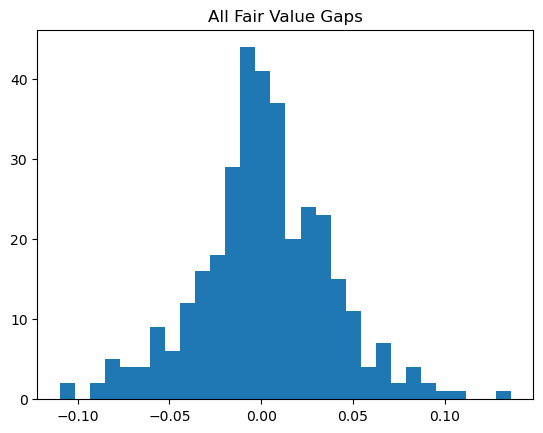

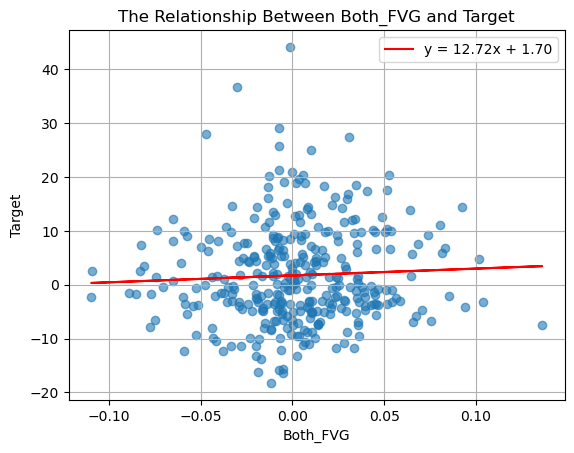

Price,Close,High,Low,Open,Volume,Target,High_2prev,Bull_FVG,Bull_FVG_Val,Low_2prev,Bear_FVG,Bear_FVG_Val,Both_FVG,Predictions,Residuals
2882,356.320007,357.459991,344.333344,350.903320,41906400,-8.697244,340.546661,1,0.010627,316.833344,0,0.000000,0.010627,1.838504,10.535748
2884,339.010010,340.326660,327.510010,336.250000,59664300,-8.304578,357.459991,0,-0.000000,344.333344,1,-0.011819,-0.011819,1.552880,9.857458
2886,319.503326,322.136658,310.000000,315.000000,70806300,-2.084486,340.326660,0,-0.000000,327.510010,1,-0.016818,-0.016818,1.489267,3.573753
2890,299.980011,307.230011,297.796661,303.566681,56480100,20.949170,331.660004,0,-0.000000,307.283325,1,-0.000178,-0.000178,1.701012,-19.248158
2892,336.290009,338.553345,319.016663,321.886658,93634200,6.092952,307.230011,1,0.035049,297.796661,0,0.000000,0.035049,2.149272,-3.943680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865,429.519989,439.359985,421.880005,437.920013,103471500,-5.860026,466.329987,0,-0.000000,440.709991,1,-0.003143,-0.003143,1.663278,7.523304
3869,401.989990,424.500000,396.339996,423.130005,118948000,-1.681629,442.489990,0,-0.000000,432.359985,1,-0.019553,-0.019553,1.454466,3.136095
3870,404.350006,412.190002,382.779999,386.299988,105506700,-3.279340,442.329987,0,-0.000000,426.559998,1,-0.035539,-0.035539,1.251047,4.530386
3877,419.399994,420.480011,405.950012,414.420013,71915600,NaN,402.799988,1,0.007511,383.760010,0,0.000000,0.007511,1.798848,NaN


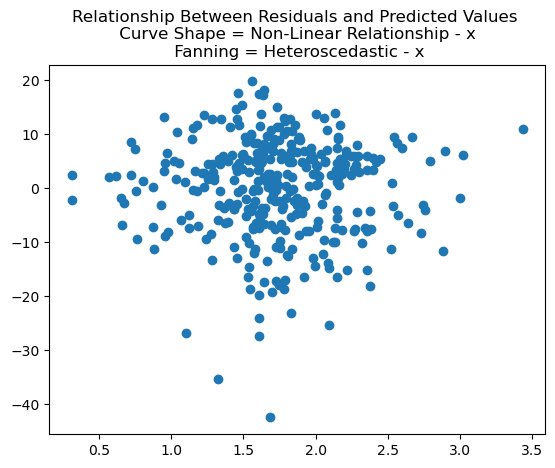

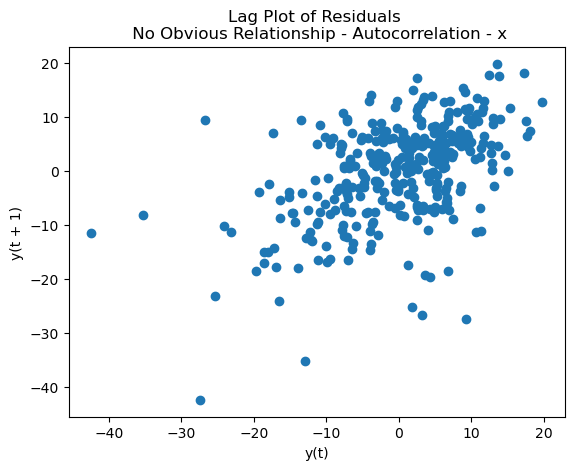

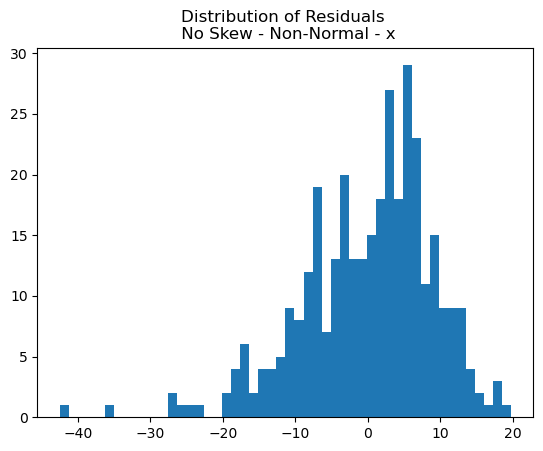

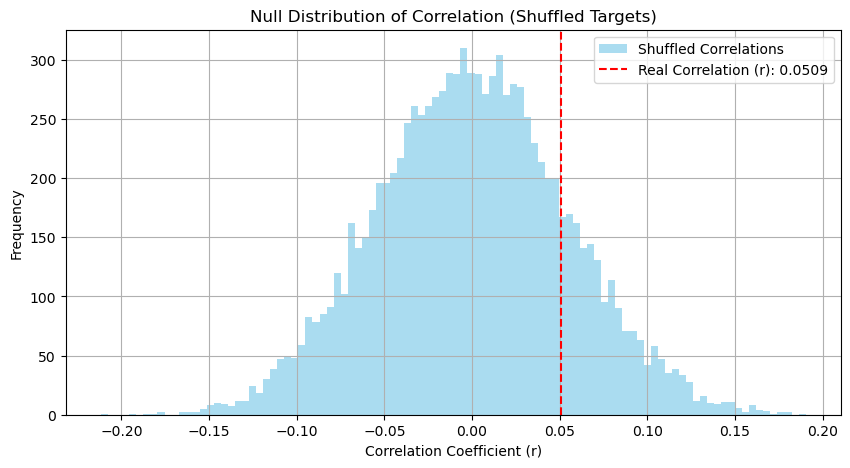

In [ ]:
# Switching from SciKit Learn Lib to Stats Models Lib for cleaner results

import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
    # p-Value is better acessible in this library 
import statsmodels.api as sm

# --- (0) GLOBAL PARAMETERS ---

# Step 1: Ticker
TICKER = "TSLA"

# Step 2: Price Behavior
INTERVAL = "1d"
if INTERVAL == "1h":
    PERIOD = "730d"
else: 
    PERIOD = "max"

# Step 3: Strategy/Independet Variable (FGV)
STRATEGY = "Both_FVG"

# Step 4: shift days back for the calculation
SHIFT = 5

# Step 5: Data Subsction (How many rows will we analyze)
LOOKBACK = 1000

# --- (1) Download Data into df ---

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):

    # Step 1: Download Data
    df = yf.download(ticker, interval = interval, period = PERIOD)

    # Step 2: Select only Level 0 of Multilevel Columns
    df.columns = df.columns.get_level_values(0)

    # Step 3: Simplifying df for Plots (Index instead Datum)
    df = df.reset_index(drop=True)

    # Step 4: Return only LOOKBACK Rows
    return df.iloc[-lookback:, :]

# --- (2) Defining Dependent/Target Variable ---

def add_target(df, shift = SHIFT):

    # Step 1: Define Delta/Price Change (Tomorrow - Today), in percentage Terms * 100
    df["Target"] = (df["Close"].shift(-shift) - df["Close"])/df["Close"] * 100

    # Step 2: Return df 
    return df

# --- (3) Defining Independent/Features Variable ---

def bull_fvg(df):
    # Calculates the high price from 2 days ago. Used to identify the gap.
    df['High_2prev'] = df['High'].shift(2)
    
    # Checks for Bullish FVG: Current Low Price > High Price 2 Days Ago.
    # If True, the gap exists, and the value is set to 1 (otherwise 0).
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    
    # Calculates the size of the FVG, normalized by the current Close price.
    df['Bull_FVG_Val'] = (df['Low'] - df['High_2prev']) * df['Bull_FVG'] / df['Close']

    return df 

def bear_fvg(df):
    # Calculates the low price from 2 days ago. Used to identify the gap.
    df['Low_2prev'] = df['Low'].shift(2)
    
    # Checks for Bearish FVG: Current High Price < Low Price 2 Days Ago.
    # If True, the gap exists, and the value is set to 1 (otherwise 0).
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    
    # Calculates the size of the FVG. The value will be negative.
    df['Bear_FVG_Val'] = (df['High'] - df['Low_2prev']) * df['Bear_FVG'] / df['Close']

    return df

def prepare_df_for_regression(df):
    # Schritt 1: Filtert den DataFrame: Behält nur Zeilen, in denen entweder ein Bull_FVG (1) 
    # ODER ein Bear_FVG (1) aufgetreten ist. Das .copy() stellt sicher, dass der 
    # gefilterte DataFrame unabhängig vom Original ist.
    df = df[(df['Bull_FVG'] == 1) | (df['Bear_FVG'] == 1)].copy()
    
    # Schritt 2: Berechnet den kombinierten FVG-Wert: Summiert den bärischen Wert (der negativ ist) 
    # und den bullischen Wert (der positiv ist). Dies ergibt den Netto-FVG-Wert.
    df['Both_FVG'] = df['Bear_FVG_Val'] + df['Bull_FVG_Val']

    # Schritt 3: Visualisiert die Verteilung aller aufgetretenen FVG-Werte.
    plt.figure()
    plt.hist(df['Both_FVG'], bins=30)
    plt.title('All Fair Value Gaps')
    
    return df

# --- (4) Generate Regression Output ---

def generate_regression_output(df, features=f'{STRATEGY}', target='Target'):
    
    # Der Target-Name wird aus globalen Variablen (SHIFT und Period) zusammengesetzt.
    # WICHTIG: Die Funktionsdefinition im Bild ist fehlerhaft. 'features' und 'target' 
    # dürfen nicht als f-Strings in der Definition stehen. Wir korrigieren das hier.
    
    # Step 1: Subset Data. Wählt die Feature- und Target-Spalte aus und entfernt alle Zeilen mit fehlenden Werten (NaN).
    subset = df[[features, target]].dropna()

    # Step 2: Reshape Data and Extract Variables
    # Konvertiert die Spalten in Series, da statsmodels keine doppelten Klammern benötigt.
    X = subset[features] 
    y = subset[target] 

    # Step 3: Model Setup (Statsmodels)
    # Fügt eine Konstante (Intercept) zur X-Variable hinzu, da OLS dies separat benötigt.
    X_with_const = sm.add_constant(X)
    
    # Definiert das OLS-Modell (Ordinary Least Squares) und führt die Regression durch (.fit()).
    model = sm.OLS(y, X_with_const).fit() 

    # Step 4: Extract Results
    # Extrahieren der gelernten Parameter und Metriken aus dem Modellobjekt.
    intercept = model.params['const']
    coefficient = model.params[features]
    r2 = model.rsquared
    p_value = model.pvalues[features]
    # Der P-Wert ist die Wahrscheinlichkeit, dass Sie den in Ihrer Stichprobe beobachteten Zusammenhang (oder einen noch extremeren) 
    # auch dann finden würden, wenn in der Realität überhaupt kein Zusammenhang (d.h. der Koeffizient wäre Null) bestehen würde.
        # P-Wert niedrig (z.B. < 0.05): Die Wahrscheinlichkeit, dass Ihr Ergebnis zufällig ist, ist sehr gering. Dies ist ein starkes Argument dafür, dass Ihr Feature statistisch signifikant ist und Vorhersagekraft besitzt.
        # P-Wert hoch (z.B. > 0.10): Die Wahrscheinlichkeit, dass Ihr Ergebnis rein zufällig ist, ist hoch. Das Feature ist nicht signifikant und liefert keinen verlässlichen Vorhersagewert.
    n_obs = len(subset)
    
    # Generiert die vorhergesagten Werte (Y-Predicted) mit der gelernten Formel.
    y_pred = model.predict(X_with_const) 

    # --- Console Summary ---
    print(model.summary())
    print(f"\nRegression Summary")
    print(f"Observations: {n_obs}")
    print(f"Coefficient: {coefficient:.6f}")
    print(f"Intercept: {intercept:.6f}")
    print(f"R^2: {r2:.6f}")
    print(f"P-Value: {p_value:.6f}")

    # --- Plot ---
    plt.figure()
    # Titel der Grafik, die die Feature- und Target-Variablen verwendet.
    plt.title(f'The Relationship Between {features} and {target}')
    # Zeichnet die Regressionslinie (Rot). y = m*x + b
    plt.plot(X, y_pred, color='red', label=f'y = {coefficient:.2f}x + {intercept:.2f}')
    # Zeichnet die tatsächlichen Datenpunkte (Scatter Plot).
    plt.scatter(X, y, alpha=0.6)
    # Beschriftung der Achsen
    plt.xlabel(f"{features}")
    plt.ylabel(f"{target}")
    # Zeigt Legende und Gitter an
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gibt den unveränderten DataFrame (df) und die wichtigsten Ergebnisse zurück.
    return df, intercept, coefficient

# --- (5) VALIDIERUNG DES REGRESSIONSMODELLS ---

def validate_regression_output(df, coefficient, intercept):
    # Berechnung der Vorhersage und des Fehlers (Residuals)
    df["Predictions"] = coefficient * df[f'{STRATEGY}'] + intercept
    df['Residuals'] = df['Predictions'] - df['Target']

    # Plot 1: Linearität & Homoskedastizität (Voraussetzung für die Regression)
    # Scatter Plot: Predicted Values vs. Residuals (Fehler).
    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    # Curve Shape = Non-Linear Relationship (x) | Fanning = Heteroscedastic (x)
    plt.title('Relationship Between Residuals and Predicted Values \n Curve Shape = Non-Linear Relationship - x \n Fanning = Heteroscedastic - x')
    
    # Plot 2: Autokorrelation (Unabhängigkeit der Fehler)
    # Lag Plot: Fehler heute vs. Fehler gestern. Sollte keine offensichtliche Struktur zeigen.
    plt.figure()
    lag_plot(df['Residuals'].dropna()) 
    plt.title('Lag Plot of Residuals \n No Obvious Relationship - Autocorrelation - x')

    # Plot 3: Normalität der Residuals (Glockenkurvenform)
    # Histogram: Zeigt die Verteilung der Fehler. Sollte annähernd normalverteilt sein.
    plt.figure()
    plt.hist(df['Residuals'], bins=50)
    plt.title('Distribution of Residuals \n No Skew - Non-Normal - x') 

    return df

# --- (6) ASSESS STATISTICAL SIGNIFICANCE (Permutation Test) ---

def assess_regression_output(df, features=f'{STRATEGY}', target='Target', n=10000):
    # Wählt die sauberen Daten (Features und Target)
    subset = df[[features, target]].dropna()
    X = subset[features]
    y = subset[target]
    
    # Berechnet den tatsächlichen Korrelationskoeffizienten (r) zwischen X und Y
    real_r = np.corrcoef(X, y)[0, 1] 
    correlations = []
    
    # Permutationstest: 10.000 Mal mischen und Korrelation neu berechnen
    for i in range(n):
        # Mischt die Zielvariable Y zufällig, um eine 'Null-Verteilung' zu simulieren.
        shuffled_y = np.random.permutation(y) 
        # Berechnet die Korrelation zwischen dem echten Feature X und dem Zufalls-Target
        r = np.corrcoef(X, shuffled_y)[0, 1]
        correlations.append(r)
        
    # Plotten der Null-Verteilung
    plt.figure(figsize=(10, 5))
    plt.hist(correlations, bins=100, alpha=0.7, color='skyblue', label='Shuffled Correlations')
    
    # Vertikale Linie für die tatsächliche Korrelation
    plt.axvline(real_r, color='red', linestyle='--', label=f'Real Correlation (r): {real_r:.4f}')
    
    plt.title('Null Distribution of Correlation (Shuffled Targets)')
    plt.xlabel('Correlation Coefficient (r)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    return df

# --- 3. HAUPT-EXECUTION (MAIN) ---

def main():
    # Annahme: Diese Schritte laden und bereiten die Daten vor
    df = get_data()
    df = add_target(df) 
    df = bull_fvg(df) 
    df = bear_fvg(df)
    df = prepare_df_for_regression(df)
    # Regression durchführen und Ergebnisse zuweisen
    # Annahme: generate_regression_output gibt df, intercept und coefficient zurück.
    df, fit_intercept, fit_coefficient = generate_regression_output(df) 
    # 1. Statistische Validierung der Regression (visuell)
    df = validate_regression_output(df, fit_coefficient, fit_intercept) 
    # 2. Statistische Signifikanz prüfen (Permutationstest)
    df = assess_regression_output(df) 
    

    return df

df = main()
df